In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tikzplotlib
import math

In [555]:
#import matplotlib
#matplotlib.rcParams['mathtext.fontset'] = 'custom'
#matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
#matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
#matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

In [556]:
#random.seed(1)
#np.random.seed(1)

In [557]:
#Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [558]:
data = pd.read_csv('../data/grad_school.csv', decimal=",", delimiter = ';')
data = data.apply(pd.to_numeric)

In [559]:
data.head()

,ID,Gender_F,Gender_M,Race_B,Race_A,Race_W,GRE_Verbal,GRE_Quant,Admit,Help_1,Help_2,Help_3,Help_4,Help_5,Help_6
0,1,1,0,1,0,0,149,165,0,-0.195324,1.457841,148.591467,165.124328,149,165
1,2,1,0,0,1,0,164,159,0,1.615721,0.065457,163.876684,158.714743,164,159
2,3,1,0,0,0,1,140,153,0,-1.177895,0.412405,140.298566,152.953129,140,153
3,4,0,1,1,0,0,149,156,0,-0.194927,0.409056,148.594817,156.012119,149,156
4,5,0,1,0,1,0,153,154,0,0.268613,-0.043410,152.507090,153.536663,153,154


In [560]:
data = data.drop(['Admit','Help_1','Help_2','Help_3','Help_4','Help_5','Help_6'], axis = 1)

In [561]:
data.head()

,ID,Gender_F,Gender_M,Race_B,Race_A,Race_W,GRE_Verbal,GRE_Quant
0,1,1,0,1,0,0,149,165
1,2,1,0,0,1,0,164,159
2,3,1,0,0,0,1,140,153
3,4,0,1,1,0,0,149,156
4,5,0,1,0,1,0,153,154


In [562]:
#data = data.sample(frac=1).reset_index(drop=True)

In [563]:
data.head()

,ID,Gender_F,Gender_M,Race_B,Race_A,Race_W,GRE_Verbal,GRE_Quant
0,1,1,0,1,0,0,149,165
1,2,1,0,0,1,0,164,159
2,3,1,0,0,0,1,140,153
3,4,0,1,1,0,0,149,156
4,5,0,1,0,1,0,153,154


In [564]:
data_cluster = data.drop(['ID','Gender_M','Gender_F','Race_W','Race_B','Race_A'], axis = 1)

In [565]:
#Standardize the data
#data_cluster['GRE_Verbal'] = ((data_cluster['GRE_Verbal']-data_cluster['GRE_Verbal'].mean())/data_cluster['GRE_Verbal'].std())
#data_cluster['GRE_Quant'] = ((data_cluster['GRE_Quant']-data_cluster['GRE_Quant'].mean())/data_cluster['GRE_Quant'].std())

In [566]:
data_cluster.head()

,GRE_Verbal,GRE_Quant
0,149,165
1,164,159
2,140,153
3,149,156
4,153,154


In [567]:
data_cluster_array = data_cluster.to_numpy()

In [568]:
data_cluster_array

array([[149, 165],
       [164, 159],
       [140, 153],
       ...,
       [146, 165],
       [148, 161],
       [158, 145]])

In [569]:
init = np.array([[data_cluster['GRE_Verbal'].min(), data_cluster['GRE_Quant'].min()],[data_cluster['GRE_Verbal'].max(), data_cluster['GRE_Quant'].max()]],np.float64)
#init = np.array([[170, 130],[170, 130]],np.float64)
kmeans = KMeans(n_clusters=2, n_init=1, max_iter=100, init=init).fit(data_cluster_array)

In [570]:
labels = kmeans.labels_

In [571]:
kmeans.inertia_

47517.145097273955

In [572]:
kmeans.cluster_centers_

array([[147.35873016, 146.21904762],
       [155.08070175, 160.74736842]])

In [573]:
data['Cluster'] = kmeans.labels_

In [574]:
data['Cluster'].value_counts()

0    316
1    284
Name: Cluster, dtype: int64

In [575]:
data.head(150)

,ID,Gender_F,Gender_M,Race_B,Race_A,Race_W,GRE_Verbal,GRE_Quant,Cluster
0,1,1,0,1,0,0,149,165,1
1,2,1,0,0,1,0,164,159,1
2,3,1,0,0,0,1,140,153,0
3,4,0,1,1,0,0,149,156,1
4,5,0,1,0,1,0,153,154,1
5,6,0,1,0,0,1,141,153,0
6,7,1,0,1,0,0,145,150,0
7,8,1,0,0,1,0,165,160,1
8,9,1,0,0,0,1,148,157,1
9,10,0,1,1,0,0,156,144,0


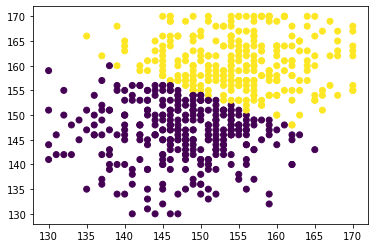

In [576]:
plt.scatter(data_cluster_array[:, 0], data_cluster_array[:, 1], c=labels)

In [577]:
#Group fairness
print(len(data[(data.Gender_F == 1) & (data.Cluster == 1)]))
print(len(data[(data.Gender_M == 1) & (data.Cluster == 1)]))
print('---')
print(len(data[(data.Race_B == 1) & (data.Cluster == 1)]))
print(len(data[(data.Race_A == 1) & (data.Cluster == 1)]))
print(len(data[(data.Race_W == 1) & (data.Cluster == 1)]))
print('---')
print(len(data[(data.Gender_F == 1) & (data.Race_B == 1) & (data.Cluster == 1)]))
print(len(data[(data.Gender_F == 1) & (data.Race_A == 1) & (data.Cluster == 1)]))
print(len(data[(data.Gender_F == 1) & (data.Race_W == 1) & (data.Cluster == 1)]))
print('---')
print(len(data[(data.Gender_M == 1) & (data.Race_B == 1) & (data.Cluster == 1)]))
print(len(data[(data.Gender_M == 1) & (data.Race_A == 1) & (data.Cluster == 1)]))
print(len(data[(data.Gender_M == 1) & (data.Race_W == 1) & (data.Cluster == 1)]))

138
146
---
92
96
96
---
44
46
48
---
48
50
48


In [578]:
#Algorithm is splitting along the wrong hyperplane, can't expect it to split into good and bad performers with random start centroids...
#What if we set the initial cluster centers to (170,170,6) and (130,130,0)? -> Seems to work! 'Fairness Through Awareness'
#Or: We just manually optimize the distance to these points?
#Next: 1) Try on an unknown test set, 2) Use the K-Means as predictor?, 3) Train a classifier (SVM, LogReg) to that!, 4) Compare 2 and 3
#'Pareto-Fairness': Check if there are any observations, where a rejected applicant is strictly worse in the GRE scores than an accepted one (individual fairness)
#Check this set for any other form of unfairness (equalized odds etc.)

In [579]:
dist = np.linalg.norm(data_cluster_array[0]-[170,170])

In [580]:
temp = list()
for i in range(0,len(data_cluster_array)):
    dist = np.linalg.norm(data_cluster_array[i]-[170,170])
    temp.append(dist)

In [581]:
temp

[21.587033144922902,
 12.529964086141668,
 34.48187929913333,
 25.238858928247925,
 23.345235059857504,
 33.61547262794322,
 32.01562118716424,
 11.180339887498949,
 25.553864678361276,
 29.5296461204668,
 30.805843601498726,
 32.7566787083184,
 8.54400374531753,
 16.401219466856727,
 37.57658845611187,
 21.633307652783937,
 40.80441152620633,
 26.92582403567252,
 38.07886552931954,
 13.892443989449804,
 12.0,
 21.93171219946131,
 46.861498055439924,
 27.80287754891569,
 37.48332962798263,
 2.0,
 20.518284528683193,
 34.20526275297414,
 16.492422502470642,
 39.11521443121589,
 8.0,
 10.0,
 39.20459156782532,
 35.84689665786984,
 42.941821107167776,
 13.601470508735444,
 29.410882339705484,
 29.0,
 15.556349186104045,
 19.1049731745428,
 16.401219466856727,
 28.319604517012593,
 39.44616584663204,
 17.11724276862369,
 32.55764119219941,
 41.10960958218893,
 49.4064773081425,
 25.942243542145693,
 20.615528128088304,
 20.808652046684813,
 26.419689627245813,
 39.824615503479755,
 23.2594

In [582]:
data['Distance'] = temp

In [583]:
data

,ID,Gender_F,Gender_M,Race_B,Race_A,Race_W,GRE_Verbal,GRE_Quant,Cluster,Distance
0,1,1,0,1,0,0,149,165,1,21.587033
1,2,1,0,0,1,0,164,159,1,12.529964
2,3,1,0,0,0,1,140,153,0,34.481879
3,4,0,1,1,0,0,149,156,1,25.238859
4,5,0,1,0,1,0,153,154,1,23.345235
5,6,0,1,0,0,1,141,153,0,33.615473
6,7,1,0,1,0,0,145,150,0,32.015621
7,8,1,0,0,1,0,165,160,1,11.180340
8,9,1,0,0,0,1,148,157,1,25.553865
9,10,0,1,1,0,0,156,144,0,29.529646


In [584]:
alpha = 0.5

In [585]:
data = data.sort_values(by=['Distance'])
data = data.reset_index(drop=True)

In [586]:
data

,ID,Gender_F,Gender_M,Race_B,Race_A,Race_W,GRE_Verbal,GRE_Quant,Cluster,Distance
0,26,1,0,0,1,0,170,168,1,2.000000
1,209,0,1,0,1,0,170,167,1,3.000000
2,109,1,0,1,0,0,167,169,1,3.162278
3,399,1,0,0,0,1,168,167,1,3.605551
4,80,1,0,0,1,0,166,167,1,5.000000
5,421,1,0,1,0,0,165,170,1,5.000000
6,536,1,0,0,1,0,168,165,1,5.385165
7,577,1,0,1,0,0,164,170,1,6.000000
8,460,0,1,1,0,0,170,164,1,6.000000
9,166,0,1,1,0,0,164,168,1,6.324555


In [587]:
temp = list()
cutoff = math.ceil(len(data)*alpha)
for i in range(0,len(data)):
    if (i<cutoff):
        temp.append(1)
    else:
        temp.append(0)
    

In [588]:
data['Admit'] = temp

In [589]:
data

,ID,Gender_F,Gender_M,Race_B,Race_A,Race_W,GRE_Verbal,GRE_Quant,Cluster,Distance,Admit
0,26,1,0,0,1,0,170,168,1,2.000000,1
1,209,0,1,0,1,0,170,167,1,3.000000,1
2,109,1,0,1,0,0,167,169,1,3.162278,1
3,399,1,0,0,0,1,168,167,1,3.605551,1
4,80,1,0,0,1,0,166,167,1,5.000000,1
5,421,1,0,1,0,0,165,170,1,5.000000,1
6,536,1,0,0,1,0,168,165,1,5.385165,1
7,577,1,0,1,0,0,164,170,1,6.000000,1
8,460,0,1,1,0,0,170,164,1,6.000000,1
9,166,0,1,1,0,0,164,168,1,6.324555,1


In [590]:
data_admit = data[data['Admit']==1]
data_reject = data[data['Admit']==0]

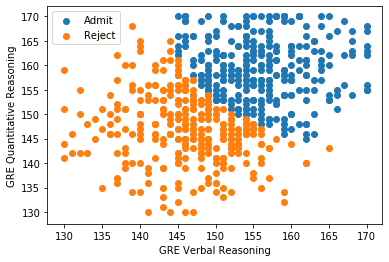

In [591]:
plt.scatter(data_admit['GRE_Verbal'], data_admit['GRE_Quant'], label='Admit')
plt.scatter(data_reject['GRE_Verbal'], data_reject['GRE_Quant'], label='Reject')
plt.legend(loc="upper left")
#plt.title(r'$\alpha=0.5$')
plt.xlabel('GRE Verbal Reasoning')
plt.ylabel('GRE Quantitative Reasoning')
#tikzplotlib.save('alpha5perc.tex')

In [592]:
#Group fairness
print(len(data[(data.Gender_F == 1) & (data.Race_B == 1) & (data.Admit == 1)]))
print(len(data[(data.Gender_F == 1) & (data.Race_A == 1) & (data.Admit == 1)]))
print(len(data[(data.Gender_F == 1) & (data.Race_W == 1) & (data.Admit == 1)]))
print('---')
print(len(data[(data.Gender_M == 1) & (data.Race_B == 1) & (data.Admit == 1)]))
print(len(data[(data.Gender_M == 1) & (data.Race_A == 1) & (data.Admit == 1)]))
print(len(data[(data.Gender_M == 1) & (data.Race_W == 1) & (data.Admit == 1)]))

45
51
51
---
51
55
47
